In [70]:
import csv
import shutil
import time

import joblib
import pandas as pd
import numpy as np
import os
import re
import pathlib

import json
from IPython.core.display import SVG
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.python.keras import Model

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard
from keras.utils.vis_utils import plot_model, model_to_dot

import sakthi_helper

In [71]:
len(tf.config.list_physical_devices('GPU'))

1

In [72]:
training_dataset_path = "data/dataset_1"
test_dataset_path = "machine-learning-in-science-ii-2023/test_data/test_data"

training_labels_path = "data/combined_training_norm_1.csv"

In [73]:
df = pd.read_csv(training_labels_path)
df.shape

(14825, 3)

In [74]:
df.head()

,image_id,angle,speed
0,1,0.4375,0.0
1,2,0.8125,1.0
2,3,0.4375,1.0
3,4,0.6250,1.0
4,5,0.5000,0.0


In [75]:
df["file_name"] = df["image_id"].astype(str) + "_speed-"+ df["speed"].astype(str) + "_angle-" + df["angle"].astype(str) + ".png"
df.head()

,image_id,angle,speed,file_name
0,1,0.4375,0.0,1_speed-0.0_angle-0.4375.png
1,2,0.8125,1.0,2_speed-1.0_angle-0.8125.png
2,3,0.4375,1.0,3_speed-1.0_angle-0.4375.png
3,4,0.6250,1.0,4_speed-1.0_angle-0.625.png
4,5,0.5000,0.0,5_speed-0.0_angle-0.5.png


In [76]:
df["file_name"][0]

'1_speed-0.0_angle-0.4375.png'

In [208]:
df_preprocessed = df

In [209]:
df_preprocessed["speed-angle"] = df_preprocessed["speed"].astype(str) + "-" + df_preprocessed["angle"].astype(str)
df_preprocessed

,image_id,angle,speed,file_name,speed-angle
0,1,0.4375,0.0,1_speed-0.0_angle-0.4375.png,0.0-0.4375
1,2,0.8125,1.0,2_speed-1.0_angle-0.8125.png,1.0-0.8125
2,3,0.4375,1.0,3_speed-1.0_angle-0.4375.png,1.0-0.4375
3,4,0.6250,1.0,4_speed-1.0_angle-0.625.png,1.0-0.625
4,5,0.5000,0.0,5_speed-0.0_angle-0.5.png,0.0-0.5
...,...,...,...,...,...
14820,17623,0.8125,1.0,17623_speed-1.0_angle-0.8125.png,1.0-0.8125
14821,17624,0.8750,1.0,17624_speed-1.0_angle-0.875.png,1.0-0.875
14822,17625,0.8125,1.0,17625_speed-1.0_angle-0.8125.png,1.0-0.8125
14823,17626,0.7500,1.0,17626_speed-1.0_angle-0.75.png,1.0-0.75


In [210]:
enc = OneHotEncoder()
angles = df_preprocessed["angle"].values.reshape(-1, 1)
print(angles)
enc.fit(angles)
print(enc.categories_)
ohe_angles = pd.DataFrame(enc.transform(angles).toarray())
ohe_angles.columns = ["angle_{}".format(col) for col in ohe_angles.columns]
ohe_angles

[[0.4375]
 [0.8125]
 [0.4375]
 ...
 [0.8125]
 [0.75  ]
 [0.5   ]]
[array([0.    , 0.0625, 0.125 , 0.1875, 0.25  , 0.3125, 0.375 , 0.4375,
       0.5   , 0.5625, 0.625 , 0.6875, 0.75  , 0.8125, 0.875 , 0.9375,
       1.    ])]


,angle_0,angle_1,angle_2,angle_3,angle_4,angle_5,angle_6,angle_7,angle_8,angle_9,angle_10,angle_11,angle_12,angle_13,angle_14,angle_15,angle_16
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14820,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
14821,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
14822,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
14823,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [211]:
df_preprocessed = pd.concat([df_preprocessed, ohe_angles], axis=1)
df_preprocessed

,image_id,angle,speed,file_name,speed-angle,angle_0,angle_1,angle_2,angle_3,angle_4,...,angle_7,angle_8,angle_9,angle_10,angle_11,angle_12,angle_13,angle_14,angle_15,angle_16
0,1,0.4375,0.0,1_speed-0.0_angle-0.4375.png,0.0-0.4375,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.8125,1.0,2_speed-1.0_angle-0.8125.png,1.0-0.8125,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,3,0.4375,1.0,3_speed-1.0_angle-0.4375.png,1.0-0.4375,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.6250,1.0,4_speed-1.0_angle-0.625.png,1.0-0.625,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.5000,0.0,5_speed-0.0_angle-0.5.png,0.0-0.5,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14820,17623,0.8125,1.0,17623_speed-1.0_angle-0.8125.png,1.0-0.8125,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
14821,17624,0.8750,1.0,17624_speed-1.0_angle-0.875.png,1.0-0.875,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
14822,17625,0.8125,1.0,17625_speed-1.0_angle-0.8125.png,1.0-0.8125,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
14823,17626,0.7500,1.0,17626_speed-1.0_angle-0.75.png,1.0-0.75,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [212]:
labels = ["speed"]+["angle_{}".format(i) for i in range(17)]
df_preprocessed[labels] = df_preprocessed[labels].astype(int)
df_preprocessed

,image_id,angle,speed,file_name,speed-angle,angle_0,angle_1,angle_2,angle_3,angle_4,...,angle_7,angle_8,angle_9,angle_10,angle_11,angle_12,angle_13,angle_14,angle_15,angle_16
0,1,0.4375,0,1_speed-0.0_angle-0.4375.png,0.0-0.4375,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,2,0.8125,1,2_speed-1.0_angle-0.8125.png,1.0-0.8125,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,3,0.4375,1,3_speed-1.0_angle-0.4375.png,1.0-0.4375,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,4,0.6250,1,4_speed-1.0_angle-0.625.png,1.0-0.625,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,5,0.5000,0,5_speed-0.0_angle-0.5.png,0.0-0.5,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14820,17623,0.8125,1,17623_speed-1.0_angle-0.8125.png,1.0-0.8125,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
14821,17624,0.8750,1,17624_speed-1.0_angle-0.875.png,1.0-0.875,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
14822,17625,0.8125,1,17625_speed-1.0_angle-0.8125.png,1.0-0.8125,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
14823,17626,0.7500,1,17626_speed-1.0_angle-0.75.png,1.0-0.75,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


## Train Test Split

In [119]:
train_df, validation_df = train_test_split(df_preprocessed, test_size=0.2, random_state=39, stratify=df[["speed", "angle"]])
print(train_df.shape, len(train_df["image_id"].unique()))
print(validation_df.shape, len(validation_df["image_id"].unique()))

(11860, 21) 11860
(2965, 21) 2965


In [120]:
files = os.listdir(test_dataset_path)
test_image_id_list = []
for file in files:
    image_id = file.split(".")[0]
    test_image_id_list.append(image_id)

test_df = pd.DataFrame()
test_df["image_id"]=sorted(test_image_id_list, key=sakthi_helper.natural_keys)
test_df["file_name"] = df["image_id"].astype(str) + ".png"


In [121]:
test_df.to_csv("submissions/test_submission_template.csv", index=False)
test_df.head()

,image_id,file_name
0,1,1.png
1,2,2.png
2,3,3.png
3,4,4.png
4,5,5.png


## Experimentation params

In [225]:
experiment = 4

In [226]:
if experiment == 1:
    #-------- R R --------------------------------------------------------------------------
    dataset_path = "data/dataset_1"
    flow_from = "dataframe"
    output_layer={'regression_output': [1, 'relu', 'mean_squared_error', 'accuracy'], 'regression_output': [1, 'relu', 'mean_squared_error', 'accuracy']}
    print(output_layer)
    target_label = ["speed", "angle"]
    print(target_label)
    model_type = 'CNN_R_R'
    print(model_type)
    n_class=[0]
    print(n_class)
    class_names = []
    print(class_names)
    class_names_short = []
    print(class_names_short)
    class_names_dict = '' ##{0: 'OA', 1: 'G', 2: 'AG', 3: 'HA', 4: 'PG', 5: 'CBG', 6: 'SEG', 7: 'MBG', 8: 'MBAG', 9: 'WOOS'}

if experiment == 2:
    #-------- MC --------------------------------------------------------------------------
    dataset_path = "data/dataset_1"
    flow_from = "dataframe"
    output_layer={'multi_output': [34, 'softmax', 'categorical_crossentropy', 'accuracy']}
    print(output_layer)
    target_label = ["speed-angle"]
    print(target_label)
    model_type ='CNN_MC'
    print(model_type)
    n_class=[34]
    print(n_class)
    class_names = ['Speed_0-Angle_0', 'Speed_0-Angle_1', 'Speed_0-Angle_2', 'Speed_0-Angle_3', 'Speed_0-Angle_4', 'Speed_0-Angle_5', 'Speed_0-Angle_6', 'Speed_0-Angle_7', 'Speed_0-Angle_8', 'Speed_0-Angle_9', 'Speed_0-Angle_10', 'Speed_0-Angle_11', 'Speed_0-Angle_12', 'Speed_0-Angle_13', 'Speed_0-Angle_14', 'Speed_0-Angle_15', 'Speed_0-Angle 17', 'Speed_1-Angle_0', 'Speed_1-Angle_1', 'Speed_1-Angle_2', 'Speed_1-Angle_3', 'Speed_1-Angle_4', 'Speed_1-Angle_5', 'Speed_1-Angle_6', 'Speed_1-Angle_7', 'Speed_1-Angle_8', 'Speed_1-Angle_9', 'Speed_1-Angle_10', 'Speed_1-Angle_11', 'Speed_1-Angle_12', 'Speed_1-Angle_13', 'Speed_1-Angle_14', 'Speed_1-Angle_15', 'Speed_1-Angle 17']
    print(class_names)
    class_names_short = ['S0-A1', 'S0-A2', 'S0-A3', 'S0-A4', 'S0-A5', 'S0-A6', 'S0-A7', 'S0-A8', 'S0-A9', 'S0-A10', 'S0-A11', 'S0-A12', 'S0-A13', 'S0-A14', 'S0-A15', 'S0-A16', 'S0-A17', 'S1-A1', 'S1-A2', 'S1-A3', 'S1-A4', 'S1-A5', 'S1-A6', 'S1-A7', 'S1-A8', 'S1-A9', 'S1-A10', 'S1-A11', 'S1-A12', 'S1-A13', 'S1-A14', 'S1-A15', 'S1-A16', 'S1-A17']
    print(class_names_short)
    class_names_dict = '' ##{0: 'OA', 1: 'G', 2: 'AG', 3: 'HA', 4: 'PG', 5: 'CBG', 6: 'SEG', 7: 'MBG', 8: 'MBAG', 9: 'WOOS'}

if experiment == 3:
    #-------- R MC -----------------------------------------------------------------------------
    dataset_path = "data/dataset_1"
    flow_from = "dataframe"
    output_layer={'regression_output': [1, 'relu', 'mean_squared_error', 'accuracy'], 'multi_output': [17, 'softmax', 'categorical_crossentropy', 'accuracy']}
    print(output_layer)
    target_label = ["speed"] + ["angle_{}".format(i) for i in range(17)]
    print(target_label)
    model_type = 'CNN_BC_MC'
    print(model_type)
    n_class=[0, 17]
    print(n_class)
    class_names = [[], ['Angle_0', 'Angle_1', 'Angle_2', 'Angle_3', 'Angle_4', 'Angle_5', 'Angle_6', 'Angle_7', 'Angle_8', 'Angle_9', 'Angle_10', 'Angle_11', 'Angle_12', 'Angle_13', 'Angle_14', 'Angle_15', 'Angle 17']]
    print(class_names)
    class_names_short = [[], ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17']]
    print(class_names_short)
    class_names_dict = '' ##{0: 'OA', 1: 'G', 2: 'AG', 3: 'HA', 4: 'PG', 5: 'CBG', 6: 'SEG', 7: 'MBG', 8: 'MBAG', 9: 'WOOS'}

if experiment == 4:
    #-------- BC MC ---------------------------------------------------------------------------
    dataset_path = "data/dataset_1"
    flow_from = "dataframe"
    output_layer={'binary_output': [1, 'sigmoid', 'binary_crossentropy', 'accuracy'], 'multi_output': [17, 'softmax', 'categorical_crossentropy', 'accuracy']}
    print(output_layer)
    target_label = ["speed"] + ["angle_{}".format(i) for i in range(17)]
    print(target_label)
    model_type = 'CNN_BC_MC'
    print(model_type)
    n_class=[2, 17]
    print(n_class)
    class_names = [['Speed_0', 'Speed_1'], ['Angle_0', 'Angle_1', 'Angle_2', 'Angle_3', 'Angle_4', 'Angle_5', 'Angle_6', 'Angle_7', 'Angle_8', 'Angle_9', 'Angle_10', 'Angle_11', 'Angle_12', 'Angle_13', 'Angle_14', 'Angle_15', 'Angle 17']]
    print(class_names)
    class_names_short = [['S0', 'S1'], ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17']]
    print(class_names_short)
    class_names_dict = '' ##{0: 'OA', 1: 'G', 2: 'AG', 3: 'HA', 4: 'PG', 5: 'CBG', 6: 'SEG', 7: 'MBG', 8: 'MBAG', 9: 'WOOS'}

if experiment == 5:
    #-------- BC ---------------------------------------------------------------------------
    dataset_path = "data/dataset_1"
    flow_from = "dataframe"
    output_layer={'binary_output': [1, 'sigmoid', 'binary_crossentropy', 'accuracy']}
    print(output_layer)
    target_label = ["speed"]
    print(target_label)
    model_type = 'CNN_BC'
    print(model_type)
    n_class=[2]
    print(n_class)
    class_names = ['Speed_0', 'Speed_1']
    print(class_names)
    class_names_short = ['S0', 'S1']
    print(class_names_short)
    class_names_dict = '' ##{0: 'OA', 1: 'G', 2: 'AG', 3: 'HA', 4: 'PG', 5: 'CBG', 6: 'SEG', 7: 'MBG', 8: 'MBAG', 9: 'WOOS'}

if experiment == 6:
    #-------- MC ---------------------------------------------------------------------------
    dataset_path = "data/dataset_1"
    flow_from = "dataframe"
    output_layer={'multi_output': [17, 'softmax', 'categorical_crossentropy', 'accuracy']}
    print(output_layer)
    target_label = ["angle"]
    print(target_label)
    model_type = 'CNN_MC'
    print(model_type)
    n_class=[17]
    print(n_class)
    class_names = ['Angle_0', 'Angle_1', 'Angle_2', 'Angle_3', 'Angle_4', 'Angle_5', 'Angle_6', 'Angle_7', 'Angle_8', 'Angle_9', 'Angle_10', 'Angle_11', 'Angle_12', 'Angle_13', 'Angle_14', 'Angle_15', 'Angle 17']
    print(class_names)
    class_names_short = ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17']
    print(class_names_short)
    class_names_dict = '' ##{0: 'OA', 1: 'G', 2: 'AG', 3: 'HA', 4: 'PG', 5: 'CBG', 6: 'SEG', 7: 'MBG', 8: 'MBAG', 9: 'WOOS'}

{'binary_output': [1, 'sigmoid', 'binary_crossentropy', 'accuracy'], 'multi_output': [17, 'softmax', 'categorical_crossentropy', 'accuracy']}
['speed', 'angle_0', 'angle_1', 'angle_2', 'angle_3', 'angle_4', 'angle_5', 'angle_6', 'angle_7', 'angle_8', 'angle_9', 'angle_10', 'angle_11', 'angle_12', 'angle_13', 'angle_14', 'angle_15', 'angle_16']
CNN_BC_MC
[2, 17]
[['Speed_0', 'Speed_1'], ['Angle_0', 'Angle_1', 'Angle_2', 'Angle_3', 'Angle_4', 'Angle_5', 'Angle_6', 'Angle_7', 'Angle_8', 'Angle_9', 'Angle_10', 'Angle_11', 'Angle_12', 'Angle_13', 'Angle_14', 'Angle_15', 'Angle 17']]
[['S0', 'S1'], ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17']]


## Image parameters

In [122]:
N_CLASSES = n_class  # CHANGE HERE, total number of classes    #EXP CHANGE
IMG_HEIGHT = 240  # CHANGE HERE, the image height to be resized to  
IMG_WIDTH = 320  # CHANGE HERE, the image width to be resized to     
CHANNELS = 3  # The 3 color channels, change to 1 if grayscale
COLOR_MODE = "rgb"
BATCH_SIZE = 16
SEED = 39
AUGMENTATION = "b-0.5-1.5"

## Image Generators

In [179]:
train_data_gen = ImageDataGenerator(rescale=1 / 255, horizontal_flip=False , brightness_range=(0.5, 1.5), zca_whitening=False)
                                            # contrast_stretching=True, contrast_stretching_range=(2, 98),
                                            # histogram_equalization=True ,
                                            # adaptive_equalization=True, adaptive_hist_clip_limit=0.03)

In [180]:
train_generator_images_path = dataset_path + "/train_generator_images_{}".format(AUGMENTATION) # hf_b_cs_he_ahe_zca
pathlib.Path(train_generator_images_path).mkdir(parents=True, exist_ok=True)

## Generators - Flow from DataFrame

In [227]:
target

['speed',
 'angle_0',
 'angle_1',
 'angle_2',
 'angle_3',
 'angle_4',
 'angle_5',
 'angle_6',
 'angle_7',
 'angle_8',
 'angle_9',
 'angle_10',
 'angle_11',
 'angle_12',
 'angle_13',
 'angle_14',
 'angle_15',
 'angle_16']

In [230]:
["speed", target[1:]]

['speed',
 ['angle_0',
  'angle_1',
  'angle_2',
  'angle_3',
  'angle_4',
  'angle_5',
  'angle_6',
  'angle_7',
  'angle_8',
  'angle_9',
  'angle_10',
  'angle_11',
  'angle_12',
  'angle_13',
  'angle_14',
  'angle_15',
  'angle_16']]

In [233]:
if flow_from == "dataframe":
    train_generator = train_data_gen.flow_from_dataframe(train_df, directory=dataset_path, x_col='file_name',
                                                     y_col=target, weight_col=None,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode=COLOR_MODE, classes=None, class_mode='other',
                                                     batch_size=BATCH_SIZE, shuffle=True, seed=SEED,
                                                     save_to_dir=train_generator_images_path, save_prefix='Aug-', save_format='png',
                                                     subset=None, interpolation='nearest', validate_filenames=True)


Found 11860 validated image filenames.


In [182]:
test_datagen = ImageDataGenerator(rescale=1./255)
if flow_from == "dataframe":
    validation_generator = test_datagen.flow_from_dataframe(validation_df, directory=dataset_path, x_col='file_name',
                                                     y_col=target, weight_col=None,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode=COLOR_MODE, classes=None, class_mode='other',
                                                     batch_size=BATCH_SIZE, shuffle=True, seed=SEED,
                                                     save_to_dir=None, save_prefix='', save_format='png',
                                                     subset=None, interpolation='nearest', validate_filenames=True)


Found 2965 validated image filenames.


In [183]:
if flow_from == "dataframe":
    test_generator = test_datagen.flow_from_dataframe(test_df, directory=test_dataset_path, x_col='file_name', y_col=None,                                                  weight_col=None,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode=COLOR_MODE, classes=None, class_mode=None, 
                                                     batch_size=BATCH_SIZE, shuffle=False, seed=SEED,
                                                     save_to_dir=None, save_prefix='', save_format='png',
                                                     subset=None, interpolation='nearest', validate_filenames=True)

Found 1020 validated image filenames.


## Generators - Flow from Directory

In [222]:
if flow_from == "directory":
    train_generator = train_data_gen.flow_from_directory(dataset_path,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode=COLOR_MODE, classes=None, class_mode='categorical',
                                                     batch_size=BATCH_SIZE, shuffle=True, seed=SEED,
                                                     save_to_dir=train_generator_images_path, save_prefix='Aug-', save_format='png',
                                                     subset=None, interpolation='nearest')


Found 834 images belonging to 1 classes.


In [182]:
test_datagen = ImageDataGenerator(rescale=1./255)
if flow_from == "directory":
    validation_generator = test_datagen.flow_from_dataframe(dataset_path,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode=COLOR_MODE, classes=None, class_mode='categorical',
                                                     batch_size=BATCH_SIZE, shuffle=True, seed=SEED,
                                                     save_to_dir=None, save_prefix='Aug-', save_format='png',
                                                     subset=None, interpolation='nearest')


Found 2965 validated image filenames.


In [183]:
if flow_from == "directory":
    test_generator = test_datagen.flow_from_dataframe(dataset_path,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode=COLOR_MODE, classes=None, class_mode=None,
                                                     batch_size=BATCH_SIZE, shuffle=False, seed=SEED,
                                                     save_to_dir=None, save_prefix='Aug-', save_format='png',
                                                     subset=None, interpolation='nearest')

Found 1020 validated image filenames.


In [184]:
for X_batch, y_batch in train_generator:
    print(X_batch.shape, y_batch)
    break

(16, 240, 320, 3) [[1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]]


In [224]:
for X_batch in test_generator:
    print(X_batch.shape)
    break

(16, 240, 320, 3)


## Model Parameters

In [89]:
model_config = {}

model_ID = model_config['model_id'] = "1"
model_type = model_config['model_type'] = 'CNN_BC_MC'
class_names = model_config['class_names'] = [['Speed_0', 'Speed_1'], ['Angle_0', 'Angle_1', 'Angle_2', 'Angle_3', 'Angle_4', 'Angle_5', 'Angle_6', 'Angle_7', 'Angle_8', 'Angle_9', 'Angle_10', 'Angle_11', 'Angle_12', 'Angle_13', 'Angle_14', 'Angle_15', 'Angle 17']]
class_names_short = model_config['class_names_short'] = [['S0', 'S1'], ['A0', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16']]
class_names_dict = model_config['class_names_dict'] = '' ##{0: 'OA', 1: 'G', 2: 'AG', 3: 'HA', 4: 'PG', 5: 'CBG', 6: 'SEG', 7: 'MBG', 8: 'MBAG', 9: 'WOOS'}
dataset_ID = model_config['dataset_ID'] = "dataset_1"
seed = model_config['seed'] = SEED
n_classes = model_config['n_classes'] = len(model_config['class_names'])
class_weights = model_config['class_weights'] = '' ##{0:1, 1:1 , 2:3, 3:5, 4:5, 5:1}
batch_size = model_config['batch_size'] = BATCH_SIZE
n_epochs = model_config['n_epochs'] = 10
hidden_layers = model_config['hidden_layers'] = ['C16_K3', 'BN', 'MP_2', 'C32_K3', 'BN', 'MP_2', 'C64_K3', 'BN', 'MP_2', 'C128_K3', 'BN', 'MP_2', 'C256_K3', 'BN', 'MP_2', 'F', '256', 'D_0.2', '128', 'D_0.2', '64', 'D_0.2']
activation_fns = model_config['activation_fns'] = ['relu', ['sigmoid', 'softmax']]
n_layers = model_config['n_layers'] = 0

optimizer = model_config['optimizer'] = "adam"
initializer = model_config['initializer'] = "glorot_uniform"
loss = model_config['loss'] = ["binary_crossentropy", "categorical_crossentropy"]
loss_short = model_config['loss_short'] = ["bce", "cce"]
metrics = model_config['metrics'] = "accuracy"
preprocess = model_config['preprocess'] = "normalize_rescale-[0,1]"
augmentation = model_config['augmentation'] = AUGMENTATION  #"hf, br_0.4_1.3, zca_w" #"-" # #
regularisation = model_config['regularisation'] = "-"  #"1_BN, 1_Dropout_0.3 D" #"4_Dropout_0.3 in MP,D" #"-" # # #"3_Dropout_0.3 in F,D"  #    #"6 Batch Norm layers"   ##  #"-"   #"5_Dropout_0.3 in MP,D"
additional_params = model_config['additional_params'] = "-"

# ---------- CNN --------------------
input_shape = model_config['input_shape'] = (IMG_HEIGHT, IMG_WIDTH, CHANNELS)
total_train_samples = model_config['total_train_samples'] = train_df.shape[0]
total_validation_samples = model_config['total_validation_samples'] = validation_df.shape[0]
train_samples = model_config['train_samples'] = train_df.shape[0]
validation_samples = model_config['validation_samples'] = validation_df.shape[0]
train_dataset = model_config['train_dataset'] = ""
validation_dataset = model_config['validation_dataset'] = ""

## model save path

In [90]:
model_save_path = "models/CNN_models/model_{}_{}".format(model_ID, model_type)
checkpoints_save_path = "models/CNN_models/model_{}_{}/model_{}_checkpoints".format(model_ID, model_type, model_ID)
pathlib.Path(model_save_path).mkdir(parents=True, exist_ok=True)
pathlib.Path(checkpoints_save_path).mkdir(parents=True, exist_ok=True)

## Creating the CNN model

In [ ]:
#-------- R R ----------------------
output_layer1={'regression_output': [1, 'relu', 'mean_squared_error', 'accuracy'], 'regression_output': [1, 'relu', 'mean_squared_error', 'accuracy']}
#-------- MC ----------------------
output_layer2={'multi_output': [34, 'softmax', 'categorical_crossentropy', 'accuracy']}
#-------- R MC ----------------------
output_layer3={'regression_output': [1, 'relu', 'mean_squared_error', 'accuracy'], 'multi_output': [17, 'softmax', 'categorical_crossentropy', 'accuracy']}
#-------- BC MC ----------------------
output_layer4={'binary_output': [1, 'sigmoid', 'binary_crossentropy', 'accuracy'], 'multi_output': [17, 'softmax', 'categorical_crossentropy', 'accuracy']}

In [185]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, CHANNELS)
print(input_shape)
model = sakthi_helper.create_CNN_model(input_shape, hidden_layers, pretrained_model=None, num_non_trainable_layers=1,
                     output_layer=output_layer1,
                     init='normal', optimize='adam')

print("Model Summary : ", model.summary())

model_parameters = model.count_params()
print("Model Parameters : ", model_parameters)

n_layers = 0
for i, layer in enumerate(model.layers):  # base_model.layers
    n_layers += 1
    print(i, layer.name)
print("num layers: ", n_layers)

model_name =  "{}_{}_D-{}_A-{}_E-{}_B-{}_PP-{}_R-{}_EXTRA-{}".format(model_ID, model_type, dataset_ID, augmentation, n_epochs, batch_size, preprocess,
                                                                      regularisation, additional_params)

print("Model_name   : ", model_name, end="\n\n")

(240, 320, 3)
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv2d_20_input (InputLayer)   [(None, 240, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 238, 318, 16  448         ['conv2d_20_input[0][0]']        
                                )                                                                 
                                                                                                  
 batch_normalization_20 (BatchN  (None, 238, 318, 16  64         ['conv2d_20[0][0]']              
 ormalization)                  )                                             

model_plotted


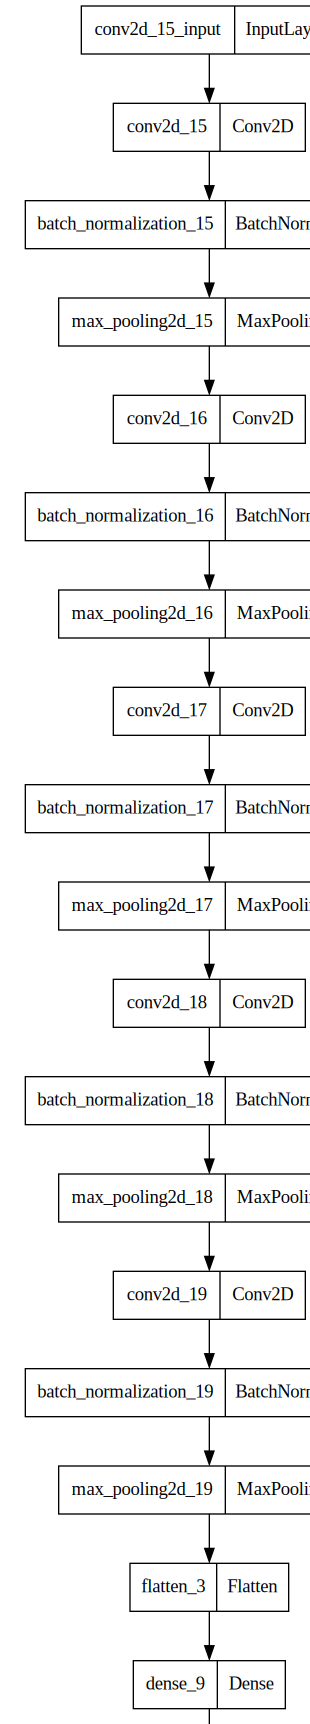

In [172]:
plot_model(model, to_file=model_save_path + "\\{}_plot.png".format(model_name), show_shapes=True)
print("model_plotted")
SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Save model config

In [173]:
#--------------------------   SAVE MODEL CONFIGURATION  -------------------------------------------

# serialize model to JSON
model_json = model.to_json()

model_config_path = model_save_path
pathlib.Path(model_config_path).mkdir(parents=True, exist_ok=True)

print("Model_config_path : ", model_config_path)

model_config_file = model_config_path + "\\model_{}_config.json".format(model_ID)

with open(model_config_file, "w") as json_file:
    json_file.write(model_json)
    print("Model_config_saved in \n {}".format(model_config_file))

Model_config_path :  models/CNN_models/model_1_CNN_BC_MC
Model_config_saved in 
 models/CNN_models/model_1_CNN_BC_MC\model_1_config.json


In [174]:
#---------------------------  SAVE MODEL DETAILS  -------------------------------------------------

model_info_file = model_save_path + "\\model_{}_build_details.json".format(model_ID)

with open(model_info_file, 'w') as outfile:
    json.dump(model_config, outfile, indent=4)
    print("model_info_file saved in \n {}".format(model_info_file))

model_info_file saved in 
 models/CNN_models/model_1_CNN_BC_MC\model_1_build_details.json


In [175]:
#--------------------------  CSV DATA  ----------------------------------------------------

header_list = []
header_list.append('Model ID')
header_list.append('Model Type')
header_list.append('Dataset ID')
header_list.append('Total train Samples')
header_list.append('Total Validation samples')
header_list.append('Train Samples')
header_list.append('Validation Samples')
header_list.append('Seed')
header_list.append('Input shape')
header_list.append('N classes')
header_list.append('Class names')
header_list.append('Class weights')
header_list.append('Preprocessing')
header_list.append('Augmentation')
header_list.append('N layers')
header_list.append('Architecture')
header_list.append('Model Parameters')
header_list.append('Initializer')
header_list.append('Optimizer')
header_list.append('Loss function')
header_list.append('Regularisation')
header_list.append('Metrics')
header_list.append('Batch size')
header_list.append('N epochs')

header_list.append('Train loss')
header_list.append('Train accuracy')
header_list.append('Test loss')
header_list.append('Test accuracy')
header_list.append('Sub Model ID')
header_list.append('Validation loss')
header_list.append('Validation accuracy')
header_list.append('Additional params')
header_list.append('Remarks')

model_details = []
model_details.append(model_ID)
model_details.append(model_type)
model_details.append(dataset_ID)
model_details.append(total_train_samples)
model_details.append(total_validation_samples)
model_details.append(train_samples)
model_details.append(validation_samples)
model_details.append(seed)
model_details.append(input_shape)
model_details.append(n_classes)
model_details.append(class_names)
model_details.append(class_weights)
model_details.append(preprocess)
model_details.append(augmentation)
model_details.append(n_layers)
model_details.append(hidden_layers)
model_details.append(model_parameters)
model_details.append(initializer)
model_details.append(optimizer)
model_details.append(loss_short)
model_details.append(regularisation)
model_details.append(metrics)
model_details.append(batch_size)
model_details.append(n_epochs)

print("Length of header list : ", len(header_list))
print("Length of model details_list : ", len(model_details))

Length of header list :  33
Length of model details_list :  24


In [186]:
#---------------------------------  CALLBACKS  --------------------------------------------------------

# metrics_1 = Metrics()

#------------  CHECKPOINTS  -----------------------

model_metrics = "_{epoch:02d}-{loss:.4f}-{acc:.4f}-{val_loss:.4f}-{val_acc:.4f}"

filepath = checkpoints_save_path + "\\{}_weights".format(model_ID) + model_metrics + ".hdf5"
check_point = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False,
                              save_weights_only=False, mode='auto', period=1)

#-------------  CSV LOGGER  ----------------------

# CSVLogger(filename, separator=',', append=False)
csv_log_path = model_save_path + '\\model_{}_training_{}.log'.format(model_ID, int(time.time()))
csv_logger = CSVLogger(csv_log_path, append=False)

#-------------  EARLY STOPPING  --------------------

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20)

# reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=patience_lr, verbose=1, epsilon=1e-4,
                                   # mode='min')

#-------------  TENSORBOARD  ------------------------

NAME = "model_{}_logs_{}".format(model_ID, int(time.time()))
tensorboard_path = model_save_path + "\\logs\\{}".format(NAME)
pathlib.Path(tensorboard_path).mkdir(parents=True, exist_ok=True)

tensorboard = TensorBoard(log_dir=tensorboard_path)

## Model training

In [187]:
history = model.fit(train_generator, epochs=n_epochs,
                                      steps_per_epoch= total_train_samples/BATCH_SIZE,
                                      verbose=1, # class_weight=class_weights,
                                      validation_data= validation_generator,
                                      validation_steps= total_validation_samples/BATCH_SIZE,
                                      callbacks=[check_point, early_stopping]) #[csv_logger, check_point, early_stopping, tensorboard])

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node 'categorical_crossentropy/softmax_cross_entropy_with_logits' defined at (most recent call last):
    File "C:\Program Files\Python39\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Program Files\Python39\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\geeks\py39\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\geeks\py39\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\geeks\py39\lib\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "C:\Users\geeks\py39\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Program Files\Python39\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Program Files\Python39\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Program Files\Python39\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\geeks\py39\lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "C:\Users\geeks\py39\lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "C:\Users\geeks\py39\lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "C:\Users\geeks\py39\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\geeks\py39\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\geeks\py39\lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\geeks\py39\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "C:\Users\geeks\py39\lib\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "C:\Users\geeks\py39\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\geeks\py39\lib\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\geeks\py39\lib\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\geeks\py39\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\geeks\AppData\Local\Temp\ipykernel_19300\814710092.py", line 1, in <module>
      history = model.fit(train_generator, epochs=n_epochs,
    File "C:\Users\geeks\py39\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\geeks\py39\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\geeks\py39\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\geeks\py39\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\geeks\py39\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\geeks\py39\lib\site-packages\keras\engine\training.py", line 994, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\geeks\py39\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
      return self.compiled_loss(
    File "C:\Users\geeks\py39\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\geeks\py39\lib\site-packages\keras\losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "C:\Users\geeks\py39\lib\site-packages\keras\losses.py", line 272, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\geeks\py39\lib\site-packages\keras\losses.py", line 1990, in categorical_crossentropy
      return backend.categorical_crossentropy(
    File "C:\Users\geeks\py39\lib\site-packages\keras\backend.py", line 5535, in categorical_crossentropy
      return tf.nn.softmax_cross_entropy_with_logits(
Node: 'categorical_crossentropy/softmax_cross_entropy_with_logits'
logits and labels must be broadcastable: logits_size=[16,17] labels_size=[16,18]
	 [[{{node categorical_crossentropy/softmax_cross_entropy_with_logits}}]] [Op:__inference_train_function_8530]

In [ ]:
#----------------------------------  MODEL TRAINING HISTORY  ----------------------------------------------------

hist = [history.history]
print(hist, end="\n\n")
# print(hist[0]['acc'][-1])
train_loss = hist[0]['loss'][-1]
train_accuracy = hist[0]['acc'][-1]
val_loss = hist[0]['val_loss'][-1]
val_accuracy = hist[0]['val_acc'][-1]

In [ ]:
#----------------------------------  SAVING MODEL  ------------------------------------------------------

end_epoch = len(hist[0]['loss'])

model_stats = "{:.4f}_{:.4f}_{:.4f}-{:.4f}".format(train_loss ,train_accuracy ,val_loss ,val_accuracy)

model.save(model_save_path + "\\{}_end_epoch_{}_{}.h5".format(model_ID, end_epoch, model_stats))
print("model saved in \n {}".format(model_save_path))

# serialize weights to HDF5

model.save_weights(model_save_path + "\\model_{}_end_epoch_{}_weights_{}.h5".format(model_ID, end_epoch, model_stats))
print("model weights saved in \n {}".format(model_save_path))

In [ ]:
# ---------------------------  SAVE PICKLE FILE  -----------------------------------------------

joblib.dump(model, model_save_path + "\\model_{}_end_epoch_{}_weights_{}.pickle".format(model_ID, end_epoch, model_stats))

#-----------------------------------  PLOT TRAINING HISTORY  --------------------------------------------

history_plot_save_path = model_save_path + "\\{}_Training_Stats.png".format(model_name)

sakthi_helper.plot_histories(hist, history_plot_save_path)

## Loading trained model

In [ ]:
model_ID = "51F47"

model_type = "CNN_BC_MC"  # CNN_C_R   # CNN_R

epoch_ID = 14  #51F47_weights_14-0.0417-0.9856-0.1764-0.9602

dataset_ID = "3CDR_3" #""CGA_18"

model_save_path = "models/CNN_models/model_{}_{}".format(model_ID, model_type)
checkpoints_save_path = "models/CNN_models/model_{}_{}/Model_{}_Checkpoints".format(model_ID, model_type, model_ID)

model_config_file = model_save_path + "\\model_{}_config.yaml".format(model_ID)

weight_files = os.listdir(checkpoints_save_path)
print(weight_files)

for i, file in enumerate(sorted(weight_files)):

    # if i == min_val_loss_index or i == max_val_acc_index:
    # print(file)
    epoch_num = file.split("_")[-1].split("-")[0]
    # print("Epoch num : ", epoch_num)

    if int(epoch_num) == epoch_ID:
        print(file)

        weight_file_name = file


## weight_file_name = "{}_weights_16-0.0379-0.9864-0.1782-0.9571.hdf5".format(model_ID)

weight_stats = weight_file_name.split("_")[-1]
epoch_name = (weight_stats).split("-")[0]
print("Model loaded from Epoch : {}".format(epoch_name))
sub_model_ID = int(epoch_name)

#--------  LOADING MODEL WEIGHTS  ----------------
selected_model_weights_file = checkpoints_save_path + "\\" + weight_file_name # .format(model_ID, n_epochs)

src_file = selected_model_weights_file

sub_model_save_path = model_save_path + "\\{}_SubModel_{}_Val_Dataset_{}\\".format(model_ID, sub_model_ID, dataset_ID)
pathlib.Path(sub_model_save_path).mkdir(parents=True, exist_ok=True)

dest_file = sub_model_save_path + weight_file_name

if not os.path.isfile(dest_file):
    shutil.copy2(src_file, dest_file)
else:
    print("Weight file already exists in Model directory")

sub_model_weights_file = dest_file

model_config_file = model_save_path + "\\model_{}_config.yaml".format(model_ID)

loaded_model = sakthi_helper.get_ML_model(model_config_file, sub_model_weights_file)

In [ ]:
#-----------------------------------  MODEL EVALUATION  ---------------------------------------------------

loss_and_metrics = loaded_model.evaluate_generator(validation_generator,
                                                   steps=total_validation_samples / BATCH_SIZE, verbose=1)

print("Loss and Metrics : ", loss_and_metrics)

eval_loss = round(loss_and_metrics[0], ndigits=4)
eval_accuracy = round(loss_and_metrics[1] * 100 , ndigits=2)

print("{}: {:.4f}".format(loaded_model.metrics_names[0], eval_loss))
print("{}: {:.2f}".format(loaded_model.metrics_names[1], eval_accuracy))

In [ ]:
#-----------------------------------  ML EXPERIMENT DOCUMENTATION  -----------------------------------------------------

train_loss = float(weight_stats.split("-")[1])
train_accuracy = float(weight_stats.split("-")[2]) * 100
validation_loss = eval_loss
validation_accuracy = eval_accuracy
test_loss = '-'
test_accuracy = '-'

model_details.append(train_loss)
model_details.append(train_accuracy)
model_details.append(test_loss)
model_details.append(test_accuracy)
model_details.append(sub_model_ID)
model_details.append(validation_loss)
model_details.append(validation_accuracy)

print(train_loss)
print(train_accuracy)
print(test_loss)
print(test_accuracy)
print(validation_loss)
print(validation_accuracy)



model_details.append(model_config['additional_params'])

remarks = "-"
model_details.append("-")

print("-----------")
# print(len(header_list))
print(len(model_details))

print(model_details)

ML_models_path = "models/CNN_models/"
CNN_model_results_file = "\\CNN_model_results_New.csv"

CNN_model_results_csv_path = ML_models_path + CNN_model_results_file


with open(CNN_model_results_csv_path, 'a', newline='') as file:
    file_empty = os.stat(CNN_model_results_csv_path).st_size == 0
    csv_writer = csv.writer(file, lineterminator="\n")

    if file_empty:
        csv_writer.writerow(header_list)
    csv_writer.writerow(model_details)
    print("Written Experiment stats to csv")

In [ ]:
##----------------------- INFERENCE --------------------------------






In [ ]:
#-------------------------------------  PLOTING CONFUSION MATRIX  ----------------------------------------
# print(Y_pred_list)
# print(Y_test_list)
#
# print("\n", pred_val_list)
# print(y_val_list)

cnf_matrix = sakthi_helper.confusion_matrix(Y_test_list, Y_pred_list)

print(cnf_matrix)

cnf_plot_save_path = sub_model_save_path + "\\Model_{}-{}_Val_Dataset_{}_cnf_matrix.png".format(model_ID, sub_model_ID, dataset_ID)

sakthi_helper.plot_confusion_matrix(cnf_matrix, class_names, cnf_plot_save_path)

In [ ]:
#-------------------------------------  PLOTTING ROC CURVES  ---------------------------------------------

roc_plot_save_path_full = sub_model_save_path + "\\Model_{}-{}_Val_Dataset_{}_full_ROC_plot.png".format(model_ID, sub_model_ID, dataset_ID)
roc_plot_save_path_zoom = sub_model_save_path + "\\Model_{}-{}_Val_Dataset_{}_zoomed_ROC_plot.png".format(model_ID, sub_model_ID, dataset_ID)

# print(Y_one_hot_array.shape)
# print(Y_pred_one_hot_array.shape)


# sakthi_helper.plot_ROC_curves(Y_one_hot_array, Y_pred_one_hot_array, n_classes, roc_plot_save_path_full, roc_plot_save_path_zoom)

In [ ]:
#-------------------------------------  PLOT CLASSIFICATION REPORT  ----------------------------------

report = sakthi_helper.classification_report(Y_test_array, Y_pred_array, target_names=class_names)
print("Classification Report : ", report)

report_plot_save_path = sub_model_save_path + "\\Model_{}-{}_Val_Dataset_{}_Classification_Report.png".format(model_ID, sub_model_ID, dataset_ID)

sakthi_helper.plot_classification_report(report, report_plot_save_path)

In [ ]:
#-------------------------------------  SAVE CLASSIFICATION REPORT AS CSV  ------------------------------------

report_save_path = sub_model_save_path + "\\Model_{}-{}_Val_Dataset_{}_Classification_Report.csv".format(model_ID,
                                                                                               sub_model_ID, dataset_ID)

report_df = sakthi_helper.pandas_classification_report(Y_test_array, Y_pred_array, class_names)

print(report_df)

report_df.to_csv(report_save_path)